### 6.48/6.49 Scikit-Optimize 1-Dimension/Manual Search

https://scikit-optimize.github.io/stable/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (cross_val_score
                                    ,train_test_split
                                    ,GridSearchCV)

# squared exponential kernel (Martern is default in gp_minimize)
from sklearn.gaussian_process.kernels import RBF

# Gaussian Process Regressor
from skopt.learning import GaussianProcessRegressor

from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_gaussian_process
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args

# load data
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

# data seems a bit imbalanced
print(type(breast_cancer_X), type(breast_cancer_y))
y.value_counts() / len (y)

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0
)
X_train.shape, X_test.shape


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


((398, 30), (171, 30))

Determine the Hyperparameter Response Function

In [2]:
## Performing Cross-Validation
# build a model
gbm = GradientBoostingClassifier(random_state=0)

# initial grid
param_grid = dict(n_estimators = [10, 20, 50, 100, 150, 200, 250])

search = GridSearchCV(gbm, param_grid, scoring = 'accuracy', cv = 5, refit = False)

# find the best hyperparameters
search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'n_estimators': [10, 20, 50, 100, 150, 200, 250]},
             refit=False, scoring='accuracy')

In [3]:
results = pd.DataFrame(search.cv_results_)

results.sort_values(by = 'param_n_estimators', ascending = False, inplace = True)
results.reset_index(drop=True, inplace=True)

results.loc[:, ['param_n_estimators', 'mean_test_score', 'std_test_score']]

,param_n_estimators,mean_test_score,std_test_score
0,250,0.947152,0.026974
1,200,0.939652,0.024441
2,150,0.937152,0.021110
3,100,0.942184,0.015163
4,50,0.939652,0.014804
5,20,0.932120,0.013039
6,10,0.934652,0.009523


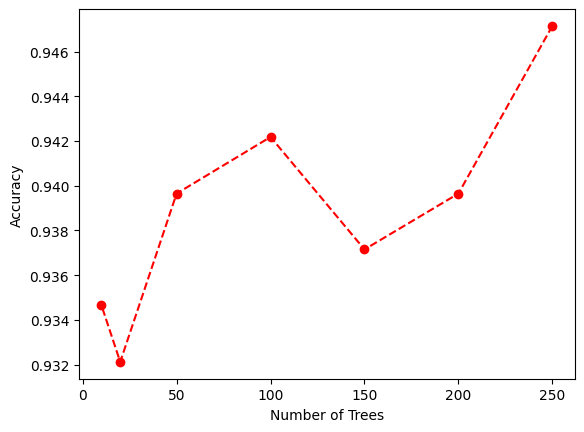

In [4]:
plt.plot(results.param_n_estimators, results.mean_test_score, "ro--")
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy');

#### Bayesian Optimization

Define the Hyperparameter Space

In [ ]:
## Performing Cross-Validation
# build a model
gbm = GradientBoostingClassifier(random_state=0)

In [5]:
# to define a HP space, we can use the Integer, Real of Categorical functions from the skopt package
    # this function means that we will sample from integer values between 10 and 250 for the parameter named n_estimators
Integer(10,250, name = 'n_estimators')
# Real(0, 0.999, name = 'min_samples_split')
# Categorical(['deviance', 'exponential'], name = 'loss')

Integer(low=10, high=250, prior='uniform', transform='identity')

In [6]:
# define the parameter grid
# single parameter
param_grid = [Integer(10, 250, name = 'n_estimators')]

# multiple parameters
# param_grid = [Integer(10, 250, name = 'n_estimators'),
#               Real(0, 0.999, name = 'min_samples_split'),
#               Integer(1, 5, name = 'max_depth'),
#               Categorical(['deviance', 'exponential'], name = 'loss')]

type(param_grid)

In [ ]:
# Define Kernel if we are using the Gaussian Process Regressor
kernel = 1.0 * RBF(Length_scale = 1.0, length_scale_bounds = (1e-1, 10.0))
kernel

# Set up the Gaussian Process
gpr = GaussianProcessRegressor(kernel = kernel,
                               normalize_y = True, noise = 'gaussian',
                               n_restarts_optimizer=2)

Define the Objective Function

In [10]:
# scikit-optimize, unlike sklearn, always minimizes the objective function
    # if we want to maximize a metric, such as accuracy, we need to negate the ouptut of the cross validation

# the decorate use_named_args() is needed to unpack the parameter space with corresponding names
@use_named_args(param_grid)
def objective(**params):
    gbm.set_params(**params)

    # optimization function
    value = np.mean(cross_val_score(gbm
                                   ,X_train
                                   ,y_train
                                   ,cv=5
                                   ,scoring='accuracy'))
    # negated to minimize accuracy
    return -value

#### Use gp_optimize to perform Bayesian Optimization

gp_optimize is useful when the call to a function is computationally expensive (neural networks, for example)

https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html

In [11]:
gp_ = gp_minimize(objective
                 ,dimensions = param_grid
                #  ,base_estimator = gpr # use if doing Bayesian Optimization with Gaussian Process Regression
                 ,n_initial_points = 2 # the number of points to evaluate f(x) to start out
                 ,acq_func = "EI"
                 ,n_calls = 20) # number of following calls to f(x)

/home/mckayc/.pyenv/versions/3.9.6/envs/HyperparameterOptimization_CourseNotes/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [13]:
# find the minimum function value
"Best Score = %.4f" % gp_.fun

'Best Score = -0.9472'

In [14]:
print("""Best Parameters:
        - n_estimators = %d""" %(gp_.x[0]))

Best Parameters:
        - n_estimators = 250


##### Evaluating Convergence of the Search

<AxesSubplot: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

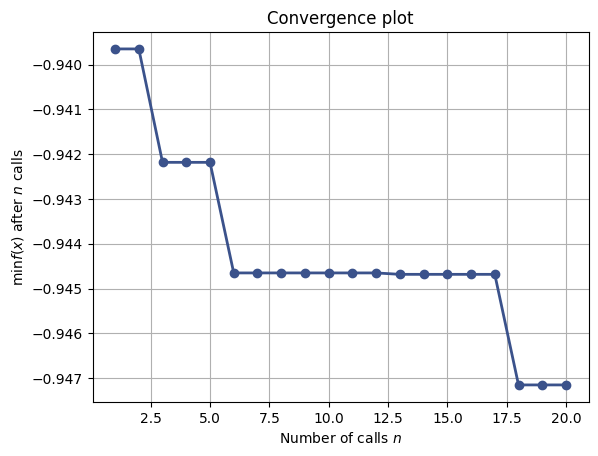

In [15]:
plot_convergence(gp_)

#### Plot Bayesian Optimization Search

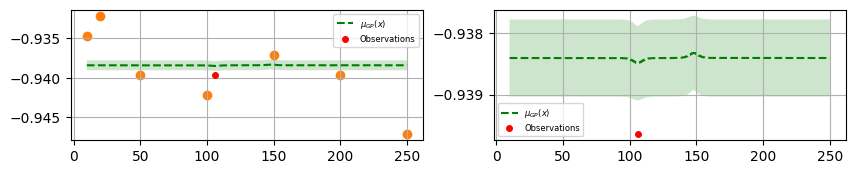

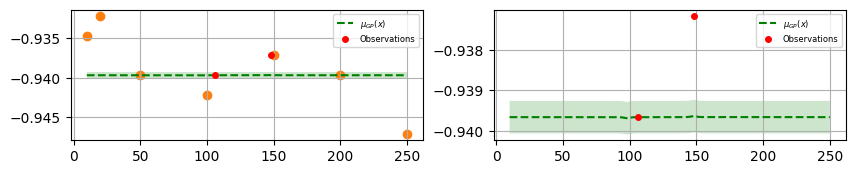

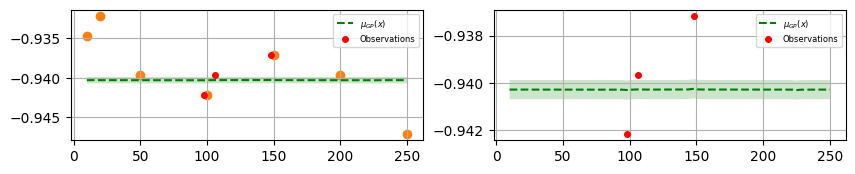

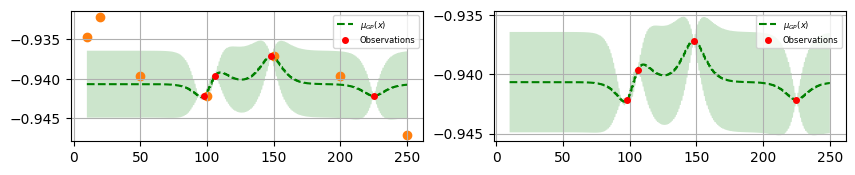

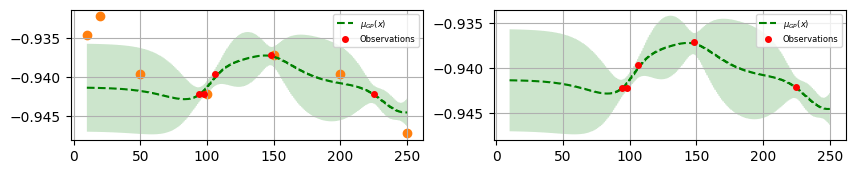

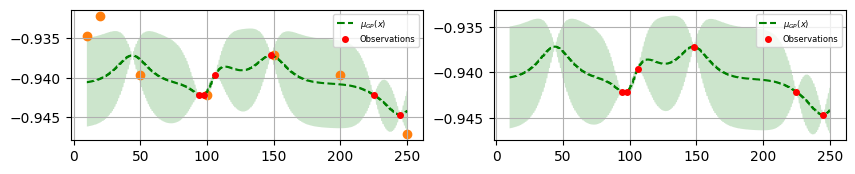

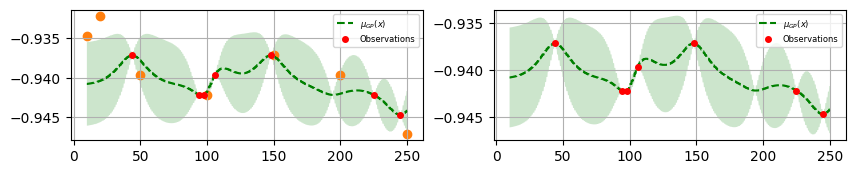

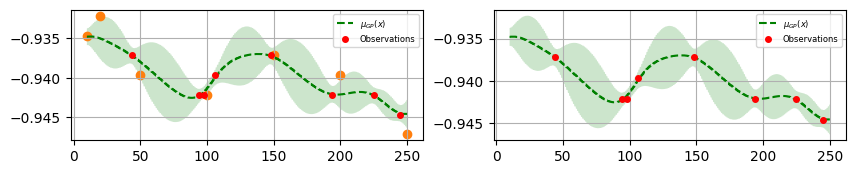

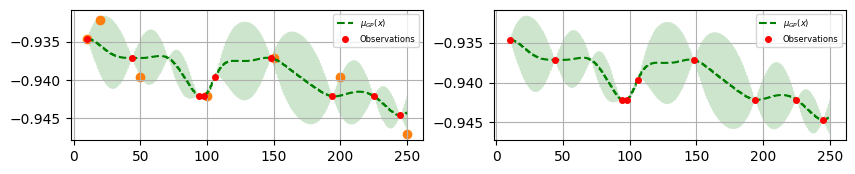

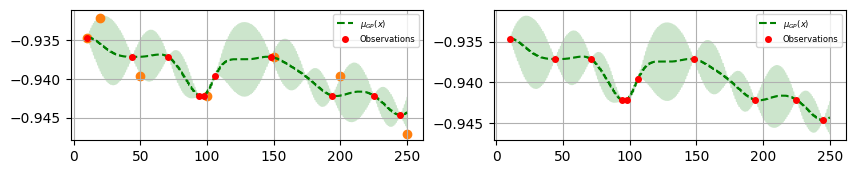

In [19]:
end = int(20/2)

for i in range(end):
    # set figure size
    plt.figure(figsize = (10,20))

    # left plot
    plt.subplot(end, 2, 2*i+1)

    # plot Gaussian Process
    ax = plot_gaussian_process(gp_,
                               n_calls = i,
                               show_legend = True,
                               show_title = False,
                               show_next_point = False,
                               show_acq_func = False)

    ax.scatter(results.param_n_estimators, -results.mean_test_score)
    ax.set_ylabel('')
    ax.set_xlabel('')

    # right plot
    plt.subplot(end, 2, 2*i+2)
    ax = plot_gaussian_process(gp_,
                               n_calls = i,
                               show_legend = True,
                               show_title = False,
                               show_next_point = False,
                               show_acq_func = False)
    ax.set_ylabel('')
    ax.set_xlabel('')